In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
sns.set()

""" 
DSC672
Team: John Matune, Mike Yacobucci, Steve Rummel
Project: Energy Consumption and Renewable Energy
Purpose: 

Import solar and wind data from the relevant source files, 
convert string-format date and time into valid datetime values,
remove unneeded columns, normalize column headers, and
export to canonical data source for further analysis.
"""

solar_prod = pd.read_csv('./raw/solararray_production.csv')
wind_prod = pd.read_csv('./raw/windfarm_production.csv')

solar_prod.rename(index=str, columns={"Electricity_KW_HR": "Solar_KWH"}, inplace=True)
solar_prod['Source'] = 'Solar'
wind_prod.rename(index=str, columns={"Electricity_KW_HR": "Wind_KWH"}, inplace=True)
wind_prod['Source'] = 'Wind'

for item in [solar_prod, wind_prod]:
    item['Hour'] = item['Hour'].astype(int) - 1
    item['Date'] = pd.to_datetime(item['Date'])
    item['Time'] = item['Date'] + pd.to_timedelta(item['Hour'], unit='h')
    item.set_index('Time', inplace=True)
    #item.fillna(0.0, inplace=True)
    item.drop(['Hour'], axis=1, inplace=True)
    item.drop(['Date'], axis=1, inplace=True)
    item.drop(['Source'], axis=1, inplace=True)

power_production = wind_prod.join(solar_prod, how='outer', sort=False)

#power_production.fillna(0.0, inplace=True)

test_pivot = power_production.groupby(power_production.index).size().reset_index(name='Count')
print(test_pivot.loc[test_pivot['Count'] > 1])

power_production.to_pickle("./processed/production_all_src.pkl")

Empty DataFrame
Columns: [Time, Count]
Index: []


In [2]:
# Build a dataset of 'everything'

#solar = power_production.loc[power_production['Source'] == 'Solar']
#wind = power_production.loc[power_production['Source'] == 'Wind']

# Export production for all dates covered, regardless of source.
#sol_all_dte = pd.Series(solar['KWH'], name='Solar')
#win_all_dte = pd.Series(wind['KWH'], name='Wind')
#all_src_all_dte = pd.concat([sol_all_dte, win_all_dte], axis=1)
#all_src_all_dte['Solar'].fillna(0.0, inplace=True)
#all_src_all_dte['Wind'].fillna(0.0, inplace=True)

# Add: Windspeed
wind_speed = pd.read_csv('./raw/windfarm_windspeed.csv')
wind_speed.rename(index=str, columns={"Date_time": "Time"}, inplace=True)
wind_speed['Time'] = pd.to_datetime(wind_speed['Time'], format='%d%b%y:%H:%M:%S')
wind_speed.drop(['Hour'], axis=1, inplace=True)
wind_speed.drop(['Location'], axis=1, inplace=True)
wind_speed.set_index('Time', inplace=True)

all_src_all_dte = power_production.join(wind_speed, how='left', sort=False)
#all_src_all_dte['Wind_Speed'].fillna(0.0, inplace=True)

#print(all_src_all_dte.head())

test_pivot = all_src_all_dte.groupby(all_src_all_dte.index).size().reset_index(name='Count')
print(test_pivot.loc[test_pivot['Count'] > 1])

Empty DataFrame
Columns: [Time, Count]
Index: []


In [3]:
# Add: Solar Angle
s_angle = pd.read_csv('./raw/solararray_solarangle_ETL.csv')
#s_angle['Date'] = pd.to_datetime(s_angle['Date'])

for field in list(s_angle):
    #s_angle[field].fillna(0.0, inplace=True)
    s_angle[field] = s_angle[field].astype(str)
    
# Pad out the Month, Day and Hour values because .to_datetime wont processed unpadded integers.
s_angle['Month'] = s_angle['Month'].apply('{:0>2}'.format)
s_angle['Day'] = s_angle['Day'].apply('{:0>2}'.format)
s_angle['Hour'] = s_angle['Hour'].apply('{:0>2}'.format)

# Create a string version of  timestamp.
s_angle['Time'] = s_angle[['Year', 'Month', 'Day']].apply(lambda x: ':'.join(x), axis=1)

# Cast the string to a datetime object.
# Note: Adding the hour at the end kept erroring out, so did it the brute
# force way by adding it after as a timedelta.
s_angle['Time'] = pd.to_datetime(s_angle['Time'], format='%Y:%m:%d')
s_angle['Time'] +=  pd.to_timedelta(s_angle['Hour'].astype(int), unit='h')

# Get rid of columns we do not need.
drop_these = ['Year', 'Month', 'Day', 'Hour', 'Location']
for field in drop_these:
    s_angle.drop([field], axis=1, inplace=True)
    
s_angle.set_index('Time', inplace=True)

test_pivot = s_angle.groupby(s_angle.index).size().reset_index(name='Count')
print(test_pivot.loc[test_pivot['Count'] > 1])

all_src_all_dte = all_src_all_dte.join(s_angle, how='left', sort=False)

test_pivot = all_src_all_dte.groupby(all_src_all_dte.index).size().reset_index(name='Count')
print(test_pivot.loc[test_pivot['Count'] > 1])

Empty DataFrame
Columns: [Time, Count]
Index: []
Empty DataFrame
Columns: [Time, Count]
Index: []


In [4]:
# Add Weather

weather = pd.read_csv('./raw/solararray_weather.csv')

for field in list(weather):
    #weather[field].fillna(0.0, inplace=True)
    weather[field] = weather[field].astype(str)
    
# Pad out the Month, Day and Hour values because .to_datetime wont processed unpadded integers.
weather['Month'] = weather['Month'].apply('{:0>2}'.format)
weather['Day'] = weather['Day'].apply('{:0>2}'.format)
weather['Hour'] = weather['Hour'].apply('{:0>2}'.format)

# Create a string version of  timestamp.
weather['Time'] = weather[['Year', 'Month', 'Day']].apply(lambda x: ':'.join(x), axis=1)

weather['Time'] = pd.to_datetime(weather['Time'], format='%Y:%m:%d')
weather['Time'] +=  pd.to_timedelta(weather['Hour'].astype(int), unit='h')
weather.set_index('Time', inplace=True)

drop_these = ['Year', 'Month', 'Day', 'Hour', 'Location']
for field in drop_these:
    weather.drop([field], axis=1, inplace=True)

all_src_all_dte = all_src_all_dte.join(weather, how='left', lsuffix='_AT_WINDFARM', rsuffix='_AT_SOLARRAY', sort=False)

#for field in list(all_src_all_dte):
    #all_src_all_dte[field].fillna(0.0, inplace=True)
    #all_src_all_dte[field] = pd.to_numeric(all_src_all_dte[field])

all_src_all_dte.reset_index(inplace=True)

test_pivot = all_src_all_dte.groupby(all_src_all_dte.index).size().reset_index(name='Count')
print(test_pivot.loc[test_pivot['Count'] > 1])    
all_src_all_dte.head()

Empty DataFrame
Columns: [index, Count]
Index: []


,Time,Wind_KWH,Solar_KWH,Wind_Speed_AT_WINDFARM,Solar_Elevation,Cloud_Cover_Fraction,Dew_Point,Humidity_Fraction,Precipitation,Pressure,Temperature,Visibility,Wind_Speed_AT_SOLARRAY
0,2010-01-04 15:00:00,NaN,14186.16,NaN,21.3412641317167,1.0,-8.3,0.7141,0.0,991.9,-3.9,16.093,5.7
1,2010-01-04 16:00:00,NaN,5898.00,NaN,16.551902902932902,1.0,-8.3,0.6827,0.0,992.2,-3.3,16.093,3.6
2,2010-01-05 09:00:00,NaN,12421.86,NaN,-2.45705075920799,1.0,-8.3,0.8437,0.0,992.9,-6.1,8.047,3.1
3,2010-01-05 10:00:00,NaN,14210.46,NaN,6.4749364246471,1.0,-8.3,0.7759,0.0,992.9,-5.0,16.093,4.1
4,2010-01-05 11:00:00,NaN,14723.64,NaN,14.045788844535801,1.0,-7.8,0.7709,0.0,993.2,-4.4,16.093,3.6


In [5]:
#Add a Timeseries index to the DataFrame
all_src_all_dte.index = pd.DatetimeIndex(all_src_all_dte.Time)
#all_src_all_dte.sort_index(inplace=True)
test_pivot = all_src_all_dte.groupby(all_src_all_dte.index).size().reset_index(name='Count')
print(test_pivot.loc[test_pivot['Count'] > 1])    
all_src_all_dte.head()

Empty DataFrame
Columns: [Time, Count]
Index: []


,Time,Wind_KWH,Solar_KWH,Wind_Speed_AT_WINDFARM,Solar_Elevation,Cloud_Cover_Fraction,Dew_Point,Humidity_Fraction,Precipitation,Pressure,Temperature,Visibility,Wind_Speed_AT_SOLARRAY
Time,,,,,,,,,,,,,
2010-01-04 15:00:00,2010-01-04 15:00:00,NaN,14186.16,NaN,21.3412641317167,1.0,-8.3,0.7141,0.0,991.9,-3.9,16.093,5.7
2010-01-04 16:00:00,2010-01-04 16:00:00,NaN,5898.00,NaN,16.551902902932902,1.0,-8.3,0.6827,0.0,992.2,-3.3,16.093,3.6
2010-01-05 09:00:00,2010-01-05 09:00:00,NaN,12421.86,NaN,-2.45705075920799,1.0,-8.3,0.8437,0.0,992.9,-6.1,8.047,3.1
2010-01-05 10:00:00,2010-01-05 10:00:00,NaN,14210.46,NaN,6.4749364246471,1.0,-8.3,0.7759,0.0,992.9,-5.0,16.093,4.1
2010-01-05 11:00:00,2010-01-05 11:00:00,NaN,14723.64,NaN,14.045788844535801,1.0,-7.8,0.7709,0.0,993.2,-4.4,16.093,3.6


In [6]:
test_pivot = all_src_all_dte.groupby(all_src_all_dte.index).size().reset_index(name='Count')
print(test_pivot.loc[test_pivot['Count'] > 1])

all_src_all_dte.to_pickle("./processed/production_all_dates_and_variables.pkl")

Empty DataFrame
Columns: [Time, Count]
Index: []


In [7]:
fields = [['Solar_KWH'],
          ['Wind_KWH'],
          ['Wind_Speed_AT_WINDFARM'],
          ['Solar_Elevation'], 
          ['Cloud_Cover_Fraction'],
          ['Dew_Point'], 
          ['Humidity_Fraction'],
          ['Precipitation'],
          ['Pressure'], 
          ['Temperature'], 
          ['Visibility']
         ]

In [8]:
for field in fields:
    print("{}: \n{}".format(field[0], all_src_all_dte[field].describe()))

Solar_KWH: 
           Solar_KWH
count   18704.000000
mean    68664.062254
std     55629.182533
min         1.441196
25%     18261.737166
50%     53860.210000
75%    114469.080000
max    205619.360000
Wind_KWH: 
           Wind_KWH
count  15385.000000
mean   12045.322327
std    12505.745777
min        0.000000
25%     2448.000000
50%     7872.000000
75%    17408.000000
max    64032.000000
Wind_Speed_AT_WINDFARM: 
       Wind_Speed_AT_WINDFARM
count            15386.000000
mean                 5.798856
std                  2.519278
min                  0.000000
25%                  3.900000
50%                  5.700000
75%                  7.400000
max                 19.800000
Solar_Elevation: 
         Solar_Elevation
count               4458
unique              4458
top     32.4228794461192
freq                   1
Cloud_Cover_Fraction: 
       Cloud_Cover_Fraction
count                 27013
unique                    6
top                     0.0
freq                  12542
Dew_Poi

Plotting Solar_KWH...
Saving Solar_KWH...
Plotting Wind_KWH...
Saving Wind_KWH...
Plotting Wind_Speed_AT_WINDFARM...
Saving Wind_Speed_AT_WINDFARM...
Plotting Solar_Elevation...


DataError: No numeric types to aggregate

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

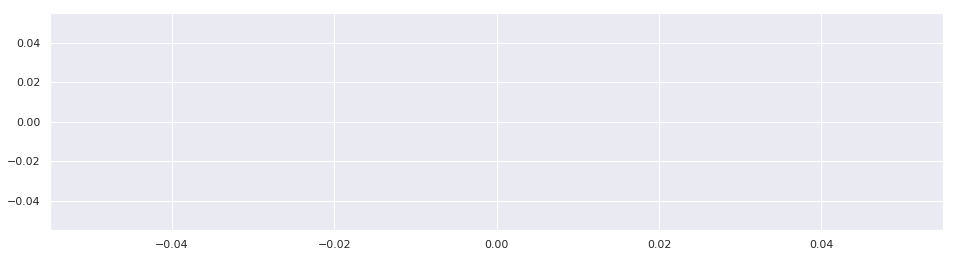

In [9]:
# Print out some nice charts of our variables.
for field in fields:
    print("Plotting {}...".format(field[0]))
    chart_dims = (16, 4)
    fig, ax = plt.subplots(figsize=chart_dims)
    sns.set()
    snplot = sns.lineplot(data=all_src_all_dte[field[0]],
                          ax=ax,
                          linewidth=1,
                          );
    snplot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));
    snplot.set_title(field[0]);
    print("Saving {}...".format(field[0]))
    #snplot.savefig("{}.png".format(field[0]));
    exp = snplot.get_figure()
    exp.savefig("./Images/{}.png".format(field[0]))
    fig.clf()
    exp.clf()